In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare Data

In [3]:
X = pd.read_csv(r"/content/drive/MyDrive/climate-wins-datasets/weather-cleaned.csv", index_col = False)
y = pd.read_csv(r"/content/drive/MyDrive/climate-wins-datasets/pleasant-weather.csv", index_col = False)

In [5]:
X.shape

(22950, 137)

In [4]:
y.shape

(22950, 16)

In [7]:
# Pick our decade (2010s)
X_decade = X[(X['DATE'].astype(str).str[:4] >= '2010') & (X['DATE'].astype(str).str[:4] <= '2019')]
y_decade = y[(y['DATE'].astype(str).str[:4] >= '2010') & (y['DATE'].astype(str).str[:4] <= '2019')]

In [8]:
# drop unnecessary columns
X_decade = X_decade.drop(['DATE', 'MONTH'], axis = 1)
y_decade = y_decade.drop(['DATE'], axis = 1)

In [9]:
X_decade.shape

(3652, 135)

In [10]:
y_decade.shape

(3652, 15)

# Grid Search

In [11]:
# setup variables properly
X = X_decade
y = y_decade

In [12]:
X.shape

(3652, 135)

In [13]:
y.shape

(3652, 15)

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y),random_state = 42)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739, 15)
(913, 135) (913, 15)


In [16]:
# Create a RF classifier
clf = RandomForestClassifier()

In [18]:
# Setup grid search hyperparameters
grid_space = {
    'max_depth': [5, 10],  # Focus on a smaller range
    'n_estimators': [30, 60],  # Reduced number of estimators
    'max_features': [10, 30],  # Focus on fewer values
    'min_samples_leaf': [1, 2],  # Smaller range
    'min_samples_split': [2, 3]  # Avoid using 1 (invalid in sklearn)
}

In [19]:
# Start the search and time said search
start = time.time()
grid = GridSearchCV(clf, param_grid=grid_space, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(X_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Search took 1.8485940456390382 minutes


In [20]:
# Print out the best hyperparameters and their score
print('Hyperparameters: '+str(model_grid.best_params_))
print('Score: '+str(model_grid.best_score_))

Hyperparameters: {'max_depth': 10, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 60}
Score: 0.6060606060606061


# Fit the classifier for all stations

In [21]:
# fit model using
# Hyperparameters: {'max_depth': 10, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 60}
clf = RandomForestClassifier(n_estimators = 60, max_depth=10, max_features=30, min_samples_leaf=1, min_samples_split=3, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=30, min_samples_split=3,
                       n_estimators=60, random_state=42)

In [22]:
# Perform predictions on the test dataset
y_pred = clf.predict(X_test)

# Get metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall: ", metrics.recall_score(y_test, y_pred, average='micro'))
print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='micro'))

Accuracy:  0.6341730558598029
Precision:  0.9205020920502092
Recall:  0.9056364787840405
F1 Score:  0.9130087789305666


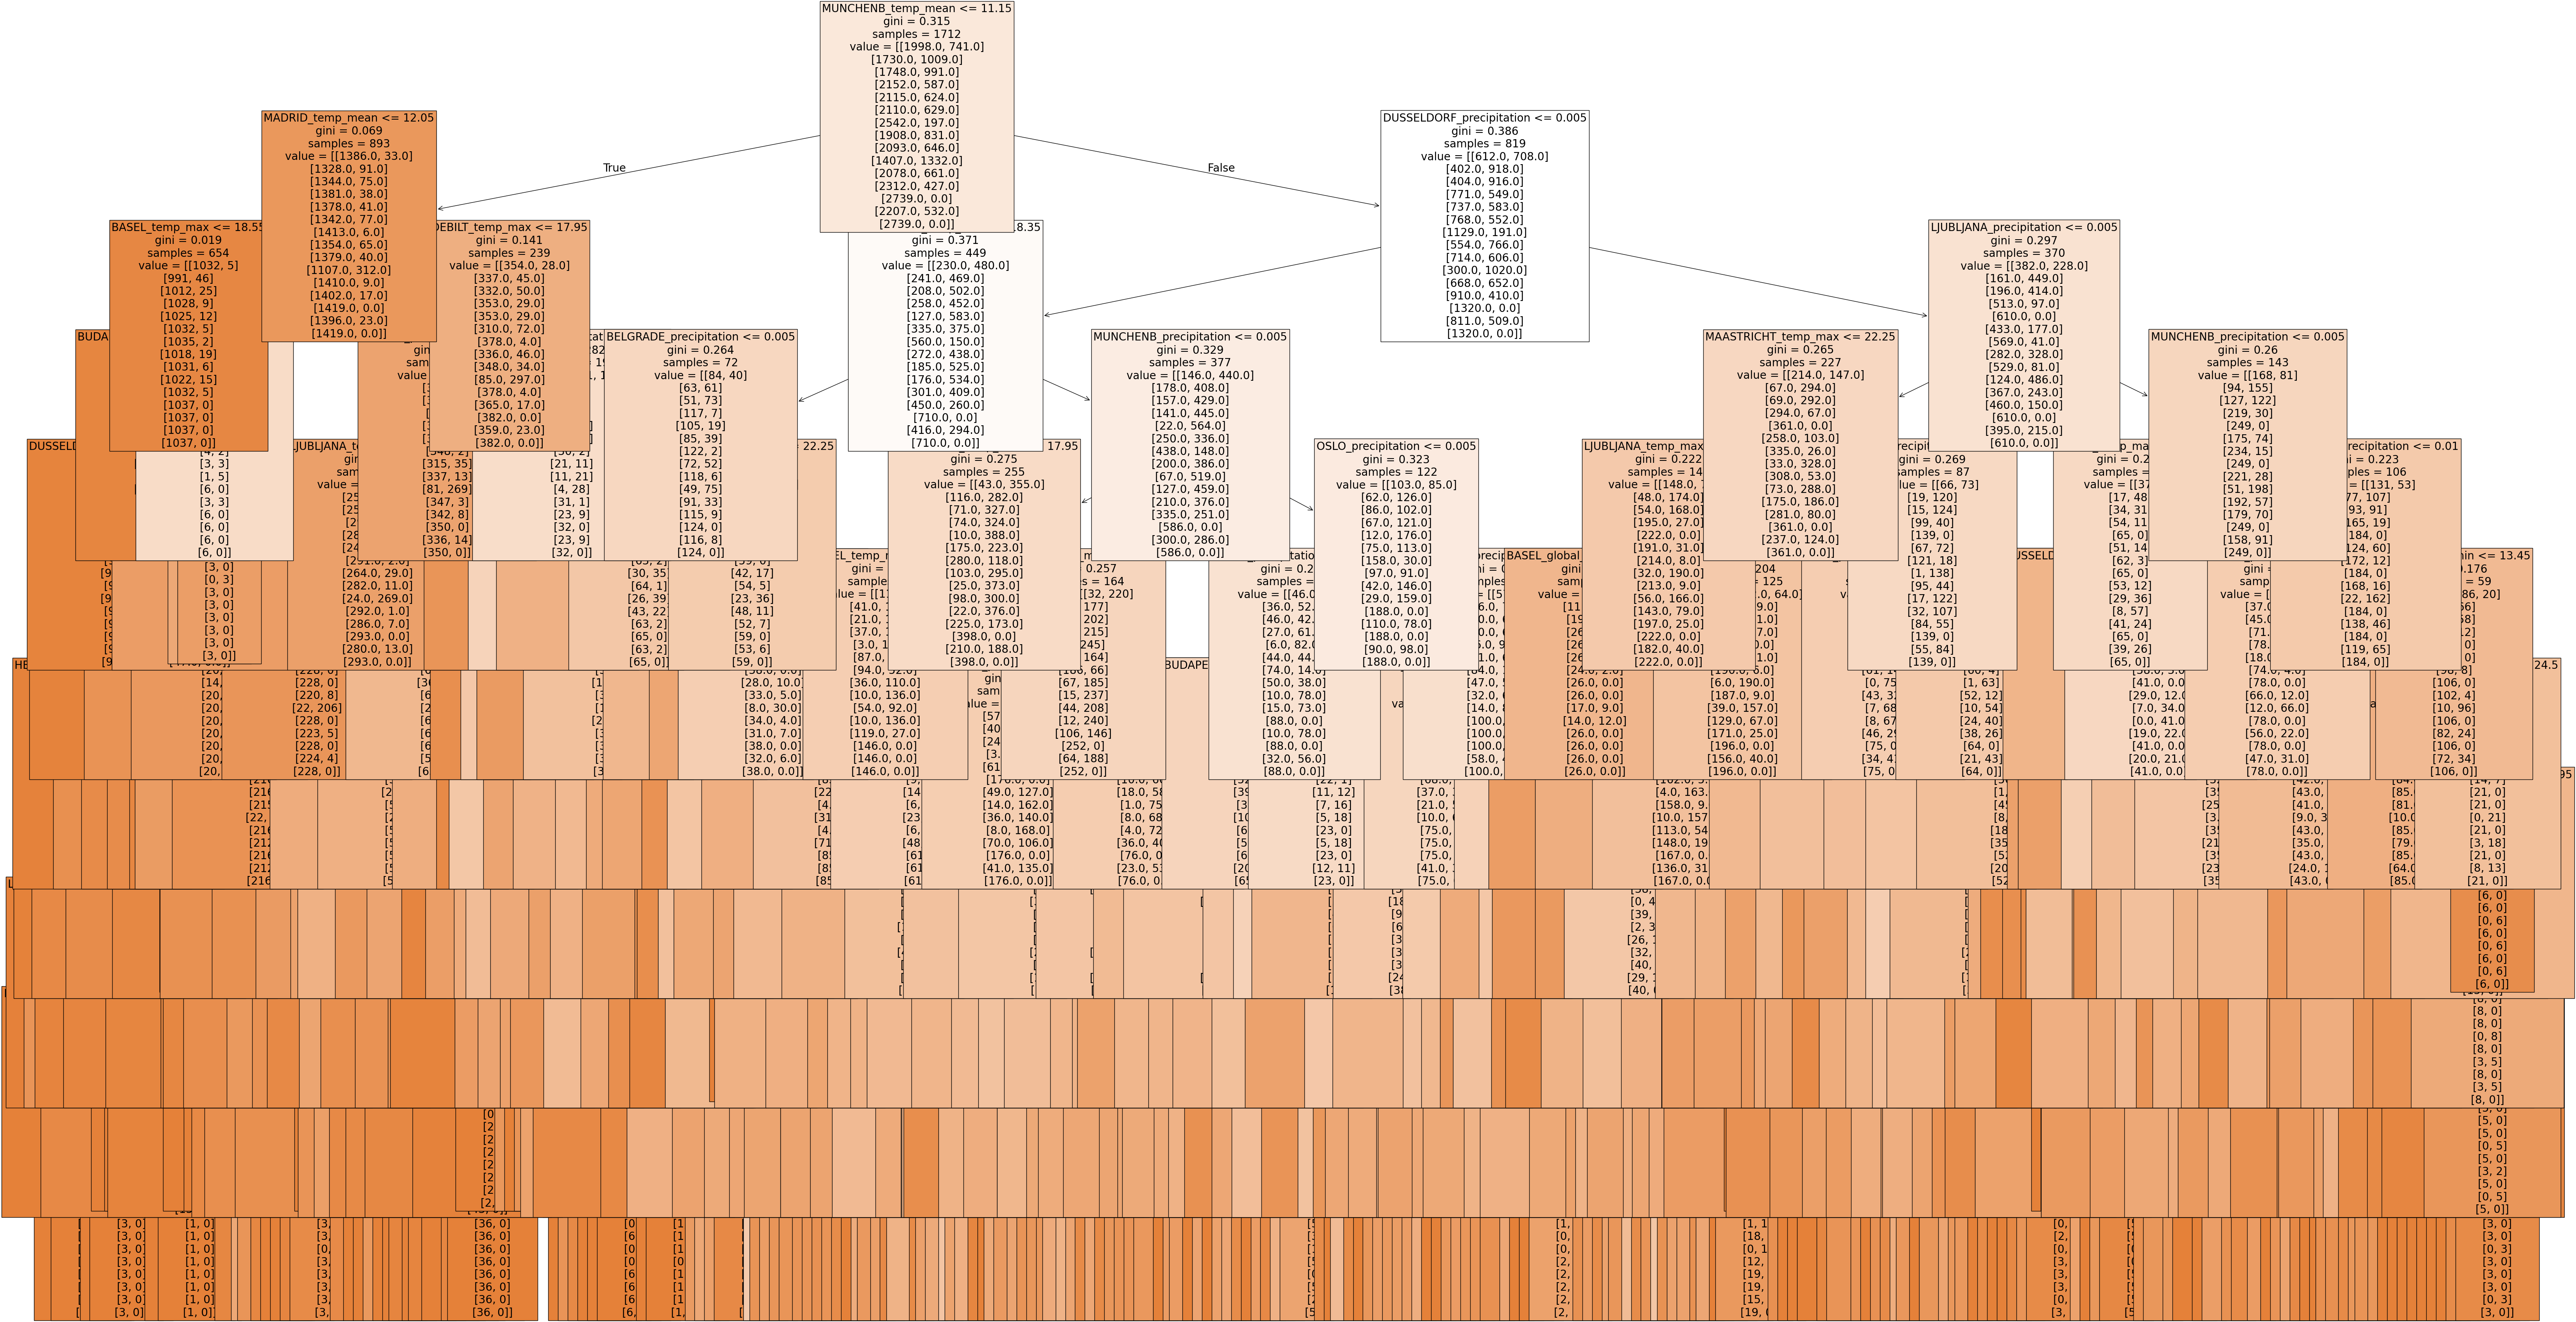

In [23]:
# plot tree
fig = plt.figure(figsize=(80,40))
plot_tree(clf.estimators_[15], fontsize = 20, feature_names = X_decade.columns, class_names=['unpleasant', 'pleasant'], filled=True);

In [27]:
# Get feature importances and reshape them
newarray = clf.feature_importances_
newarray = newarray.reshape(-1,15,9)
print(newarray.shape)
sumarray = np.sum(newarray[0], axis=1)
sumarray

(1, 15, 9)


array([0.11844142, 0.04973475, 0.05512061, 0.09528733, 0.1280913 ,
       0.04009627, 0.0261952 , 0.08820807, 0.13984116, 0.06796599,
       0.09338512, 0.03858583, 0.01601315, 0.04056647, 0.00246731])

In [28]:
# Create a set of unique station names
stations = [col.split('_')[0] for col in X_decade.columns if '_' in col]
unique_stations = set(stations)
unique_stations

{'BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA'}

In [29]:
# get importances of each station
important = pd.Series(sumarray, index = unique_stations)
important = important.sort_values(ascending = False)
important

,0
HEATHROW,0.139841
BELGRADE,0.128091
MAASTRICHT,0.118441
DEBILT,0.095287
MADRID,0.093385
MUNCHENB,0.088208
BASEL,0.067966
KASSEL,0.055121
DUSSELDORF,0.049735
LJUBLJANA,0.040566


In [30]:
# Create dataframe for importances
df_importance = pd.DataFrame({
    'Weather Station': list(unique_stations),
    'Importance': sumarray
})

df_importance = df_importance.sort_values(by='Importance', ascending = False)

{'MAASTRICHT', 'DUSSELDORF', 'KASSEL', 'DEBILT', 'BELGRADE', 'BUDAPEST', 'VALENTIA', 'MUNCHENB', 'HEATHROW', 'BASEL', 'MADRID', 'OSLO', 'STOCKHOLM', 'LJUBLJANA', 'SONNBLICK'}


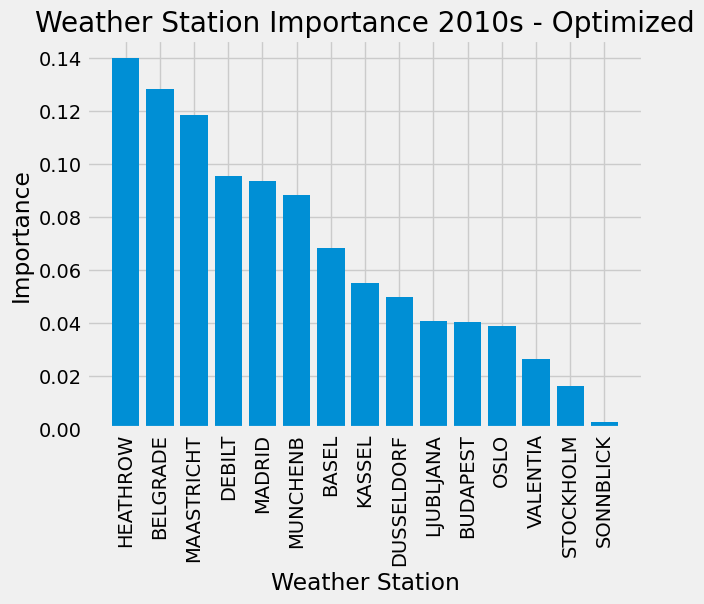

In [31]:
# Plot the feature importances
%matplotlib inline

plt.style.use('fivethirtyeight')
print(unique_stations)

plt.bar(df_importance['Weather Station'], df_importance['Importance'], orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.xlabel('Weather Station')
plt.ylabel('Importance')
plt.title('Weather Station Importance 2010s - Optimized')

plt.show()

# Oslo Random Forest

In [33]:
# Reload original data
X = pd.read_csv(r"/content/drive/MyDrive/climate-wins-datasets/weather-cleaned.csv", index_col = False)
y = pd.read_csv(r"/content/drive/MyDrive/climate-wins-datasets/pleasant-weather.csv", index_col = False)

In [34]:
# get data from oslo only
oslo_list = list(x for x in X.columns if x.find('OSLO') >=0)
oslo_list

['OSLO_cloud_cover',
 'OSLO_humidity',
 'OSLO_pressure',
 'OSLO_global_radiation',
 'OSLO_precipitation',
 'OSLO_sunshine',
 'OSLO_temp_mean',
 'OSLO_temp_min',
 'OSLO_temp_max']

In [37]:
# Get relevant data
X_oslo = X[oslo_list]
y_oslo = y['OSLO_pleasant_weather']

In [38]:
X_oslo.shape

(22950, 9)

In [39]:
y_oslo.shape

(22950,)

# Grid Search

In [40]:
X = X_oslo
y = y_oslo

In [41]:
X.shape

(22950, 9)

In [42]:
y.shape

(22950,)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y),random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17212, 9) (17212,)
(5738, 9) (5738,)


In [44]:
clf = RandomForestClassifier()

In [45]:
# Create grid search parameters (simple again)
grid_space = {
    'max_depth': [5, 10],  # Focus on a smaller range
    'n_estimators': [30, 60],  # Reduced number of estimators
    'max_features': [10, 30],  # Focus on fewer values
    'min_samples_leaf': [1, 2],  # Smaller range
    'min_samples_split': [2, 3]  # Avoid using 1 (invalid in sklearn)
}
start = time.time()
grid = GridSearchCV(clf, param_grid=grid_space, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(X_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Search took 0.5963160594304403 minutes


In [46]:
# Print grid search results
print('Hyperparameters: '+str(model_grid.best_params_))
print('Score: '+str(model_grid.best_score_))

Hyperparameters: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Score: 1.0


# Fitting the tree

In [47]:
# Hyperparameters: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
clf = RandomForestClassifier(n_estimators = 30, max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=2, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=10, n_estimators=30,
                       random_state=42)

In [48]:
# Perform predictions on the test dataset
y_pred = clf.predict(X_test)

# Get metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall: ", metrics.recall_score(y_test, y_pred, average='micro'))
print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='micro'))

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


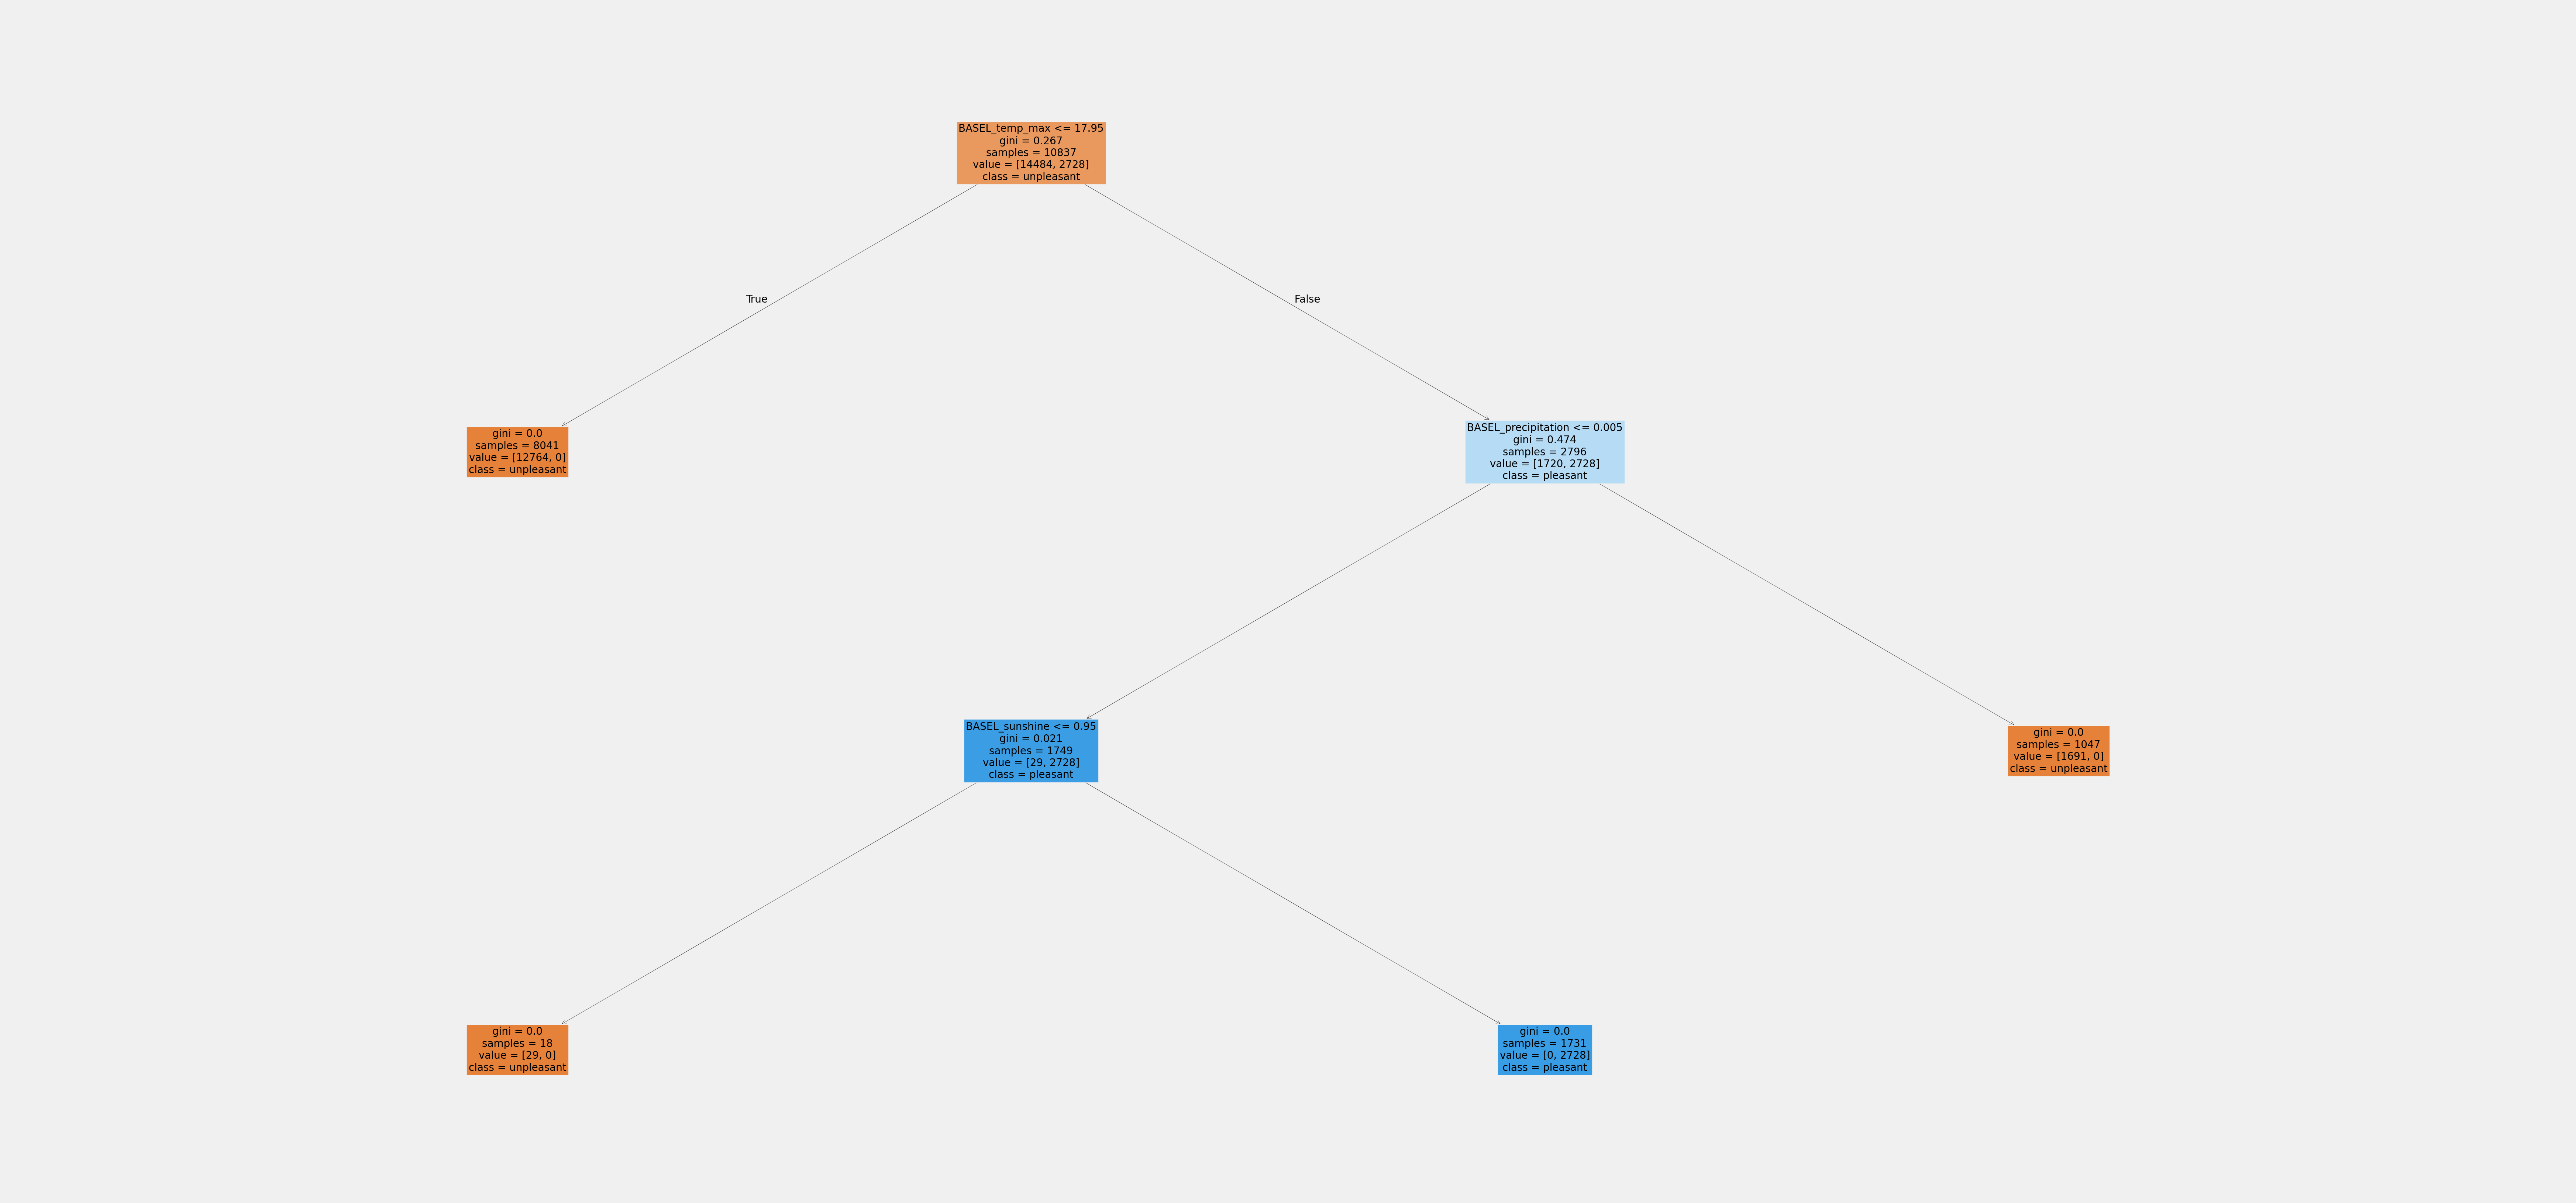

In [49]:
fig = plt.figure(figsize=(80,40))
plot_tree(clf.estimators_[15], fontsize = 20, feature_names = X_decade.columns, class_names=['unpleasant', 'pleasant'], filled=True);

In [50]:
# Set up feature importances
newarray = clf.feature_importances_
print(clf.feature_importances_.shape)
newarray

(9,)


array([0.        , 0.        , 0.        , 0.        , 0.43512378,
       0.01204112, 0.        , 0.        , 0.5528351 ])

In [51]:
# Get features
wx_list = [feature.replace('oslo_', '') for feature in oslo_list]
wx_list

['OSLO_cloud_cover',
 'OSLO_humidity',
 'OSLO_pressure',
 'OSLO_global_radiation',
 'OSLO_precipitation',
 'OSLO_sunshine',
 'OSLO_temp_mean',
 'OSLO_temp_min',
 'OSLO_temp_max']

In [52]:
# get important features and rank them
important = pd.Series(newarray, index = wx_list)
important = important.sort_values(ascending = False)
important

,0
OSLO_temp_max,0.552835
OSLO_precipitation,0.435124
OSLO_sunshine,0.012041
OSLO_cloud_cover,0.000000
OSLO_humidity,0.000000
OSLO_global_radiation,0.000000
OSLO_pressure,0.000000
OSLO_temp_mean,0.000000
OSLO_temp_min,0.000000


['OSLO_cloud_cover', 'OSLO_humidity', 'OSLO_pressure', 'OSLO_global_radiation', 'OSLO_precipitation', 'OSLO_sunshine', 'OSLO_temp_mean', 'OSLO_temp_min', 'OSLO_temp_max']


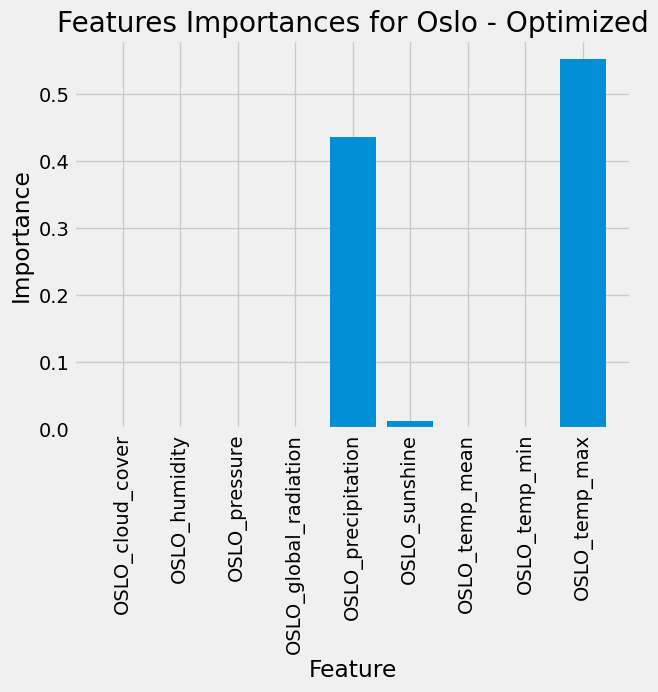

In [54]:
# Plot the results

%matplotlib inline

plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(newarray)))
print(wx_list)

plt.bar(x_values, newarray, orientation = 'vertical')
plt.xticks(x_values, wx_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Features Importances for Oslo - Optimized');


plt.show()